The evaluation logic for a complete conversation is a two-stage process that simulates a more nuanced decision-making process:

- High-Confidence "Knock-out" Decision: If a single turn within a conversation is classified with a very high probability (e.g., >85%), its class is immediately assigned to the entire conversation.

- Majority Vote: If no single turn is decisive, a majority vote is taken on all turns that exceed a minimum confidence threshold. The most frequent class among these "qualified" turns becomes the final label.



In [1]:
# SECTION 1: PROJECT CONFIGURATION AND IMPORTS

import pandas as pd
import numpy as np
import json
import os
import time
import random
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from typing import Dict, Any, List
import sys

# --- Add project root to path to import config ---
sys.path.append(os.path.abspath(os.path.join('..')))
from config import (
    PROCESSED_DATA_DIR,
    TRAIN_FILE,
    VAL_FILE,
    TEST_FILE,
    DATASET,
    TEXT_COLUMN,
    PERSON_COUPLE_COLUMN,
    RANDOM_STATE
)
print("Configuration variables imported from config.py.")


# --- Set seeds for reproducibility ---
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

Configuration variables imported from config.py.


In [2]:
# SECTION 2: DATA LOADING AND PREPARATION 

import json
import os
import pandas as pd
from sklearn.model_selection import train_test_split

def flatten_conversations_to_turns(conversations: list) -> pd.DataFrame:
    """
    Converts a list of conversation objects into a pandas DataFrame 
    where each row is a single dialogue turn.
    """
    turn_data = []
    for conversation in conversations:
        label = conversation[PERSON_COUPLE_COLUMN]
        for turn in conversation['dialogue']:
            turn_data.append({TEXT_COLUMN: turn['text'], PERSON_COUPLE_COLUMN: label})
    return pd.DataFrame(turn_data)

try:
    file_path = os.path.join(PROCESSED_DATA_DIR, DATASET)
    with open(file_path, 'r', encoding='utf-8') as f:
        all_conversations = json.load(f)

    conversation_labels = [conv[PERSON_COUPLE_COLUMN] for conv in all_conversations]

    train_conversations, test_conversations, _, _ = train_test_split(
        all_conversations,
        conversation_labels,
        test_size=0.10,
        random_state=RANDOM_STATE,
        stratify=conversation_labels
    )
    
    df_train_turns = flatten_conversations_to_turns(train_conversations)
    df_test_turns = flatten_conversations_to_turns(test_conversations)

    print(f"Total dataset: {len(all_conversations)} conversations")
    print("-" * 30)
    print(f"Training set: {len(train_conversations)} conversations ({len(df_train_turns)} turns)")
    print(f"Test set:     {len(test_conversations)} conversations ({len(df_test_turns)} turns)\n")

    # 4. Define X and y variables for consistency with the rest of the notebook
    X_train = df_train_turns[TEXT_COLUMN]
    y_train = df_train_turns[PERSON_COUPLE_COLUMN]
    X_test = df_test_turns[TEXT_COLUMN]
    y_test = df_test_turns[PERSON_COUPLE_COLUMN]

except Exception as e:
    print(f"An error occurred: {e}")
    X_train, X_test, y_train, y_test = None, None, None, None
    df_train_turns, df_test_turns = pd.DataFrame(), pd.DataFrame()


Total dataset: 1000 conversations
------------------------------
Training set: 900 conversations (6711 turns)
Test set:     100 conversations (682 turns)



In [ ]:
# SECTION 3: TURN-BASED CLASSIFIER CLASS

class TurnBasedClassifier:
    """
    Trains, optimizes, and evaluates a classification model for conversations
    based on individual dialogue turns.
    """
    def __init__(self, random_state=42):
        self.model: Any = None
        self.vectorizer: TfidfVectorizer = None
        self.label_encoder: LabelEncoder = None
        self.best_params_: Dict[str, float] = {}
        self.random_state = random_state
        self.base_estimator = LogisticRegression(
            random_state=self.random_state,
            max_iter=1000,
            class_weight='balanced'
        )

    def train(self, df_train: pd.DataFrame):
        """Trains the TF-IDF vectorizer and Logistic Regression model."""
        print("\nStarting model training...")
        X_train, y_train = df_train[TEXT_COLUMN], df_train[PERSON_COUPLE_COLUMN]

        self.label_encoder = LabelEncoder()
        y_train_encoded = self.label_encoder.fit_transform(y_train)

        self.vectorizer = TfidfVectorizer(ngram_range=(1, 4), max_features=15000, sublinear_tf=True)
        X_train_tfidf = self.vectorizer.fit_transform(X_train)

        param_grid = {
            'C': [1, 10, 50, 100],
            'penalty': ['l2'],
            'solver': ['liblinear']
        }

        grid_search = GridSearchCV(self.base_estimator, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
        grid_search.fit(X_train_tfidf, y_train_encoded)

        self.model = grid_search.best_estimator_
        print(f"Training complete. Best model parameters: {grid_search.best_params_}\n")

    @staticmethod
    def _get_conversation_level_probabilities(raw_data: List[Dict], vectorizer, model, label_encoder) -> np.ndarray:
        """
        Calculates the averaged probability distribution for each conversation.
        This is used for Top-K accuracy analysis.
        """
        all_convo_probs = []
        for conv in raw_data:
            dialogue = conv['dialogue']
            turn_texts = [turn['text'] for turn in dialogue]
            if not turn_texts:
                all_convo_probs.append(np.full(len(label_encoder.classes_), 1 / len(label_encoder.classes_)))
                continue
            
            turn_probs = model.predict_proba(vectorizer.transform(turn_texts))
            avg_convo_prob = np.mean(turn_probs, axis=0)
            all_convo_probs.append(avg_convo_prob)
        
        return np.array(all_convo_probs)

    def optimize_parameters(self, test_file_path: str):
        """Finds the optimal evaluation thresholds and margin by searching a grid."""
        print("Optimizing evaluation parameters (thresholds and margin)...")
        high_thresholds = [0.75, 0.80, 0.85]
        min_thresholds = [0.25, 0.30, 0.35, 0.40]
        margins = [0.10, 0.15, 0.20]
        best_accuracy = 0.0

        num_combinations = len(high_thresholds) * len(min_thresholds) * len(margins)
        print(f"Searching over {num_combinations} combinations...\n")

        with open(test_file_path, 'r', encoding='utf-8') as f:
            raw_data = json.load(f)

        for high_t in high_thresholds:
            for min_t in min_thresholds:
                for m in margins:
                    params = {'high_thresh': high_t, 'min_thresh': min_t, 'margin': m}
                    true_labels, pred_labels = [], []
                    for conv in raw_data:
                        pred_class = self._evaluate_conversation(conv['dialogue'], self.vectorizer, self.model, self.label_encoder, **params)
                        if pred_class:
                            true_labels.append(conv[PERSON_COUPLE_COLUMN])
                            pred_labels.append(pred_class)
                    
                    accuracy = accuracy_score(true_labels, pred_labels)
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        self.best_params_ = params

        print(f"Optimization complete.")
        print(f"Best accuracy found (using original logic): {best_accuracy:.4f}")
        print(f"Best evaluation parameters: {self.best_params_}\n")

    @staticmethod
    def _evaluate_conversation(dialogue: List[Dict], vectorizer, model, label_encoder, high_thresh: float, min_thresh: float, margin: float) -> str:
        """Applies the two-stage evaluation logic to get the Top-1 prediction."""
        turn_texts = [turn['text'] for turn in dialogue]
        if not turn_texts: return None

        turn_probs = model.predict_proba(vectorizer.transform(turn_texts))
        all_preds_with_probs = [(np.argmax(p), np.max(p)) for p in turn_probs]

        best_single_turn_idx, max_prob_overall = max(all_preds_with_probs, key=lambda item: item[1], default=(-1, 0))
        if max_prob_overall >= high_thresh:
            return label_encoder.classes_[best_single_turn_idx]

        confident_preds = [idx for idx, prob in all_preds_with_probs if prob >= min_thresh]
        if not confident_preds:
            return label_encoder.classes_[best_single_turn_idx] if best_single_turn_idx != -1 else None

        majority_class_idx, _ = Counter(confident_preds).most_common(1)[0]

        if majority_class_idx != best_single_turn_idx:
            max_prob_of_majority = max((prob for idx, prob in all_preds_with_probs if idx == majority_class_idx), default=0)
            if max_prob_overall > (max_prob_of_majority + margin):
                return label_encoder.classes_[best_single_turn_idx]

        return label_encoder.classes_[majority_class_idx]

    def evaluate(self, raw_test_data: List[Dict], verbose: bool = True) -> Dict[str, Any]:
        """
        Evaluate the model on a list of conversation objects and compute both overall and per-class performance metrics.
        """
        y_pred_probs_conversations = self._get_conversation_level_probabilities(raw_test_data, self.vectorizer, self.model, self.label_encoder)
        true_labels = [conv[PERSON_COUPLE_COLUMN] for conv in raw_test_data]
        y_true_encoded = self.label_encoder.transform(true_labels)
        
        top_1_preds_indices = np.argsort(y_pred_probs_conversations, axis=1)[:, -1]
        top_2_preds_indices = np.argsort(y_pred_probs_conversations, axis=1)[:, -2:]
        top_3_preds_indices = np.argsort(y_pred_probs_conversations, axis=1)[:, -3:]
        
        pred_labels_top1 = self.label_encoder.classes_[top_1_preds_indices]
        
        report_dict_top1 = classification_report(true_labels, pred_labels_top1, zero_division=0, output_dict=True, labels=self.label_encoder.classes_)
        
        overall_accuracy_top1 = report_dict_top1['accuracy']
        macro_avg_recall = report_dict_top1['macro avg']['recall']
        macro_avg_f1 = report_dict_top1['macro avg']['f1-score']
        weighted_avg_recall = report_dict_top1['weighted avg']['recall']
        weighted_avg_f1 = report_dict_top1['weighted avg']['f1-score']

        overall_accuracy_top2 = np.mean([y_true_encoded[i] in top_2_preds_indices[i] for i in range(len(y_true_encoded))])
        overall_accuracy_top3 = np.mean([y_true_encoded[i] in top_3_preds_indices[i] for i in range(len(y_true_encoded))])
        
        results_data = []
        for class_index, class_name in enumerate(self.label_encoder.classes_):
            class_metrics = report_dict_top1.get(class_name, {})
            indices_of_class = np.where(y_true_encoded == class_index)[0]
            
            class_top2_accuracy, class_top3_accuracy = 0.0, 0.0
            if len(indices_of_class) > 0:
                class_top2_accuracy = np.sum([y_true_encoded[i] in top_2_preds_indices[i] for i in indices_of_class]) / len(indices_of_class)
                class_top3_accuracy = np.sum([y_true_encoded[i] in top_3_preds_indices[i] for i in indices_of_class]) / len(indices_of_class)

            results_data.append({
                'Precision': class_metrics.get('precision', 0),
                'Recall (Top-1 Acc)': class_metrics.get('recall', 0),
                'F1-Score': class_metrics.get('f1-score', 0),
                'Top-2 Accuracy': class_top2_accuracy,
                'Top-3 Accuracy': class_top3_accuracy,
                'Support': int(class_metrics.get('support', 0))
            })

        results_df = pd.DataFrame(results_data, index=self.label_encoder.classes_)
        results_df.index.name = "Class"
        
        if verbose:
            print("\n" + "="*80)
            print("DETAILED PERFORMANCE REPORT (Based on Averaged Turn Probabilities)")
            print("="*80)
            formatted_df = results_df.copy()
            for col in ['Precision', 'Recall (Top-1 Acc)', 'F1-Score', 'Top-2 Accuracy', 'Top-3 Accuracy']:
                formatted_df[col] = formatted_df[col].apply(lambda x: f"{x:.2%}")
            print(formatted_df.to_string())
            
            print("\n" + "-"*80)
            print("Overall Performance Summary:")
            print(f"  - Accuracy (Top-1):       {overall_accuracy_top1:.2%}")
            print(f"  - Recall (Macro Avg):     {macro_avg_recall:.2%}")
            print(f"  - F1-Score (Macro Avg):   {macro_avg_f1:.2%}")
            print(f"  - Recall (Weighted Avg):  {weighted_avg_recall:.2%}")
            print(f"  - F1-Score (Weighted Avg):{weighted_avg_f1:.2%}")
            print("-" * 35)
            print(f"  - Top-2 Accuracy:         {overall_accuracy_top2:.2%}")
            print(f"  - Top-3 Accuracy:         {overall_accuracy_top3:.2%}")
            print("="*80)
        
        return {
            'y_true': true_labels,
            'y_pred': pred_labels_top1,
            'report_dict': report_dict_top1,
            'accuracy_top1': overall_accuracy_top1,
            'recall_macro': macro_avg_recall,
            'f1_macro': macro_avg_f1,
            'recall_weighted': weighted_avg_recall,
            'f1_weighted': weighted_avg_f1,
            'accuracy_top2': overall_accuracy_top2,
            'accuracy_top3': overall_accuracy_top3
        }

    def plot_evaluation_results(self, y_true: List[str], y_pred: List[str], report_dict: Dict):
        """Generates and displays evaluation plots: confusion matrix and report heatmap."""
        class_labels = self.label_encoder.classes_
        
        # Plot 1: Confusion Matrix
        cm = confusion_matrix(y_true, y_pred, labels=class_labels)
        fig_cm, ax_cm = plt.subplots(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, ax=ax_cm)
        ax_cm.set_title('Matrice di Confusione', fontsize=16)
        ax_cm.set_xlabel('Etichetta Predetta', fontsize=12)
        ax_cm.set_ylabel('Etichetta Reale', fontsize=12)
        plt.setp(ax_cm.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        plt.show()

        # Plot 2: Classification Report Heatmap
        df_report = pd.DataFrame(report_dict).transpose()
        fig_rep, ax_rep = plt.subplots(figsize=(10, 7))
        sns.heatmap(df_report.iloc[:-3, :-1], annot=True, cmap="YlGnBu", fmt='.2f', ax=ax_rep)
        ax_rep.set_title('Mappa di Calore del Report di Classificazione', fontsize=16)
        plt.show()



Starting model training...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\Users\Andrei\Desktop\universita\1-A-2-S\NLP\Progetto\CIPV_project\llm_env_py311\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Training complete. Best model parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}


DETAILED PERFORMANCE REPORT (Based on Averaged Turn Probabilities)
                                         Precision Recall (Top-1 Acc) F1-Score Top-2 Accuracy Top-3 Accuracy  Support
Class                                                                                                                
Controllore e Isolata                       64.29%             90.00%   75.00%         90.00%         90.00%       10
Dominante e Schiavo emotivo                 60.00%             90.00%   72.00%        100.00%        100.00%       10
Geloso-Ossessivo e Sottomessa              100.00%             40.00%   57.14%         70.00%         70.00%       10
Manipolatore e Dipendente emotiva           71.43%             50.00%   58.82%         80.00%         90.00%       10
Narcisista e Succube                        50.00%             60.00%   54.55%         70.00%         70.00%       10
Perfezionista 

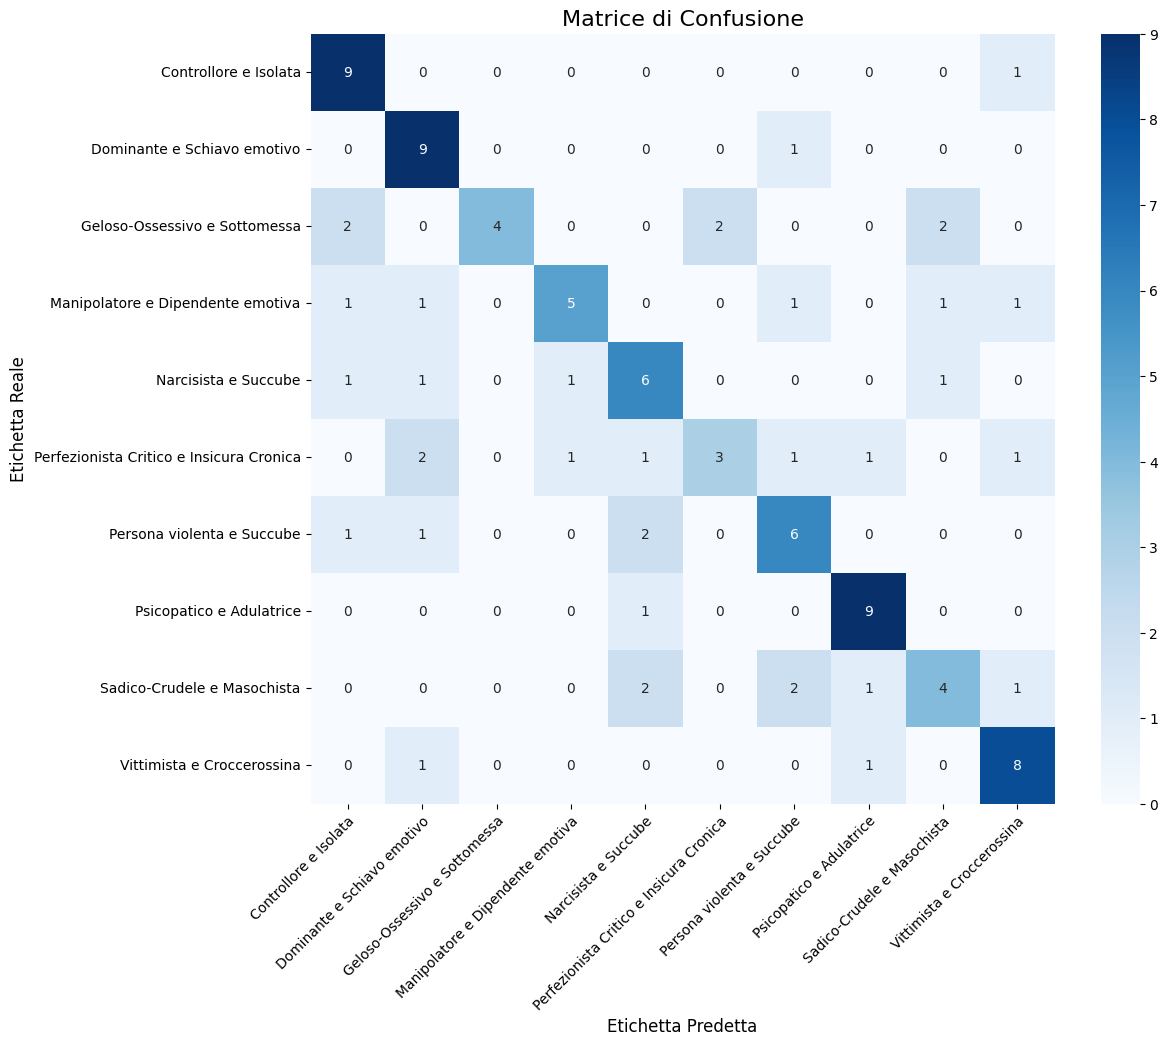

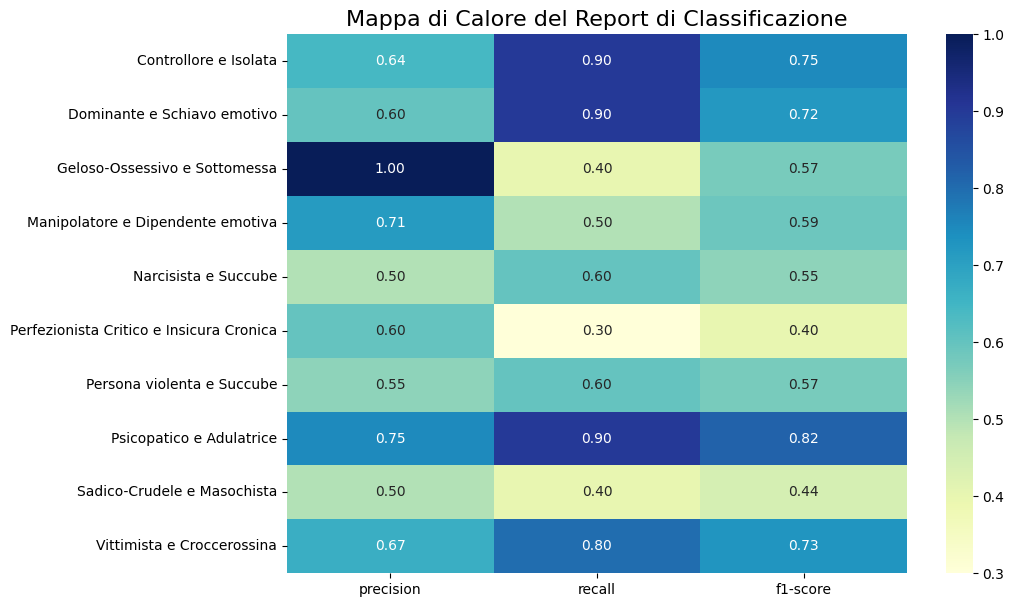

In [8]:
# SECTION 4: EXECUTION

turn_classifier = TurnBasedClassifier(random_state=RANDOM_STATE)

df_train_turns = pd.DataFrame({TEXT_COLUMN: X_train, PERSON_COUPLE_COLUMN: y_train})
turn_classifier.train(df_train_turns)

test_json_path = os.path.join(PROCESSED_DATA_DIR, TEST_FILE)

# 4. Run the final evaluation
final_results = turn_classifier.evaluate(
    test_conversations,
    verbose=True
)

print("\n" + "="*60)
print("RISULTATI VISIVI DELLA VALUTAZIONE")
print("="*60)
turn_classifier.plot_evaluation_results(
    y_true=final_results['y_true'],
    y_pred=final_results['y_pred'],
    report_dict=final_results['report_dict']
)